In [1]:
from utils import *

from persim import plot_diagrams
import umap.umap_ as umap
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.stats import linregress

In [2]:

rat_name = 'R'
mod_name = '2'
sess_name = 'OF'
day_name = 'day1'

dim = 6
ph_classes = [0,1] 
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

sspikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                 bSmooth = True, bSpeed = True)[0]

## Torus Visualisation

In [3]:
num_neurons = len(sspikes[0,:])            
times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

ssspikes = preprocessing.scale(sspikes[movetimes,:],axis = 0)

dim_red_spikes_move_scaled,__,__ = pca(ssspikes, dim = dim)
colour = dim_red_spikes_move_scaled[:,0]

In [4]:

# This takes a while to run - instead can load the saved umap embedding

# reducer = umap.UMAP(n_components=3, n_neighbors=2000, min_dist=0.8, metric='cosine', init='spectral')
# umap_embedding = reducer.fit_transform(dim_red_spikes_move_scaled)

umap_embedding = np.load('torus_embedding.npy')


/home/hs17630/anaconda3/envs/grid_cell_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


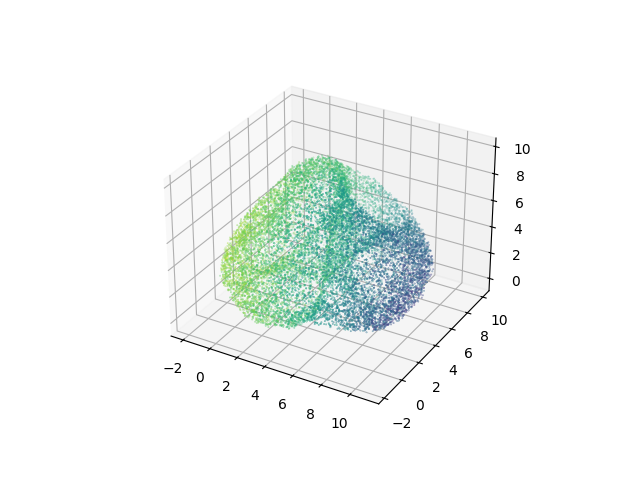

In [5]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], umap_embedding[:,2], c =  dim_red_spikes_move_scaled[:,0], s=0.1, cmap='viridis')
plt.show()

## Persistence Diagram

In [6]:
n_points = 800

indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k,
                                        n_points, 1, metric)
pca_spikes_n800 = dim_red_spikes_move_scaled[indstemp,:]

In [7]:
X = squareform(pdist(pca_spikes_n800, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

/tmp/ipykernel_15936/721473911.py:13: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


In [8]:
persistence = ripser(d, maxdim=2, coeff=coeff, do_cocycles=True, distance_matrix=True)
dgms = persistence['dgms']

In [9]:
#find the 2 longest lived 1D holes
births1 = dgms[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = dgms[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
imaxs = np.argsort(lives1)[::-1][:2] # the indices of the longest lived classes
imaxs

array([196, 153])

In [10]:
# slightly move the 1-dim holes to make them more visible
dgms[1][153,0] = dgms[1][153,0] + 0.1

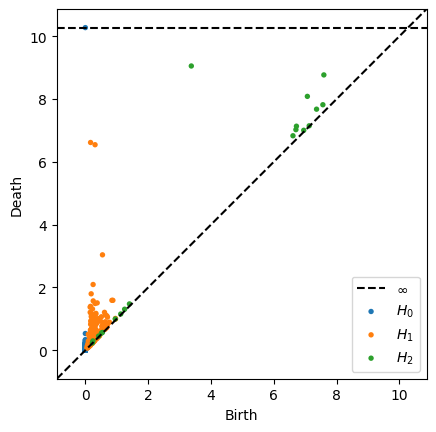

In [13]:
%matplotlib inline
plot_diagrams(dgms, show=True, legend=True, size =15)

## Rhombus plots

In [3]:
rat_name = 'R' 
mod_name = '2'
sess_name = 'OF'
day_name = 'day1' 

dim = 6
ph_classes = [0,1] 
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

sspikes,xx,yy,aa,tt = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = True, bSpeed = True)

In [4]:
spikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                         bSmooth = False, bSpeed = True)
times = np.where(np.sum(spikes>0, 1)>=1)[0]

sspikes = sspikes[times,:]
xx = xx[times]
yy = yy[times]

In [5]:
num_neurons = len(sspikes[0,:])
times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

ssspikes = preprocessing.scale(sspikes[movetimes,:],axis = 0)

In [3]:

for rat_names, mod_names, sess_names, days in ((('R',), ('2'), ('OF',), ('day1',)),
                                               ):
    for rat_name in rat_names:
        for mod_name in mod_names:
            for sess_name in sess_names:                
                for day_name in days:                
                    if rat_name + mod_name + sess_name == 'R1SWS':
                        sess_name += '_bursty'
                    file_name =   rat_name + '_' + mod_name + '_' + sess_name
                    if len(day_name)>0:
                        file_name += '_' + day_name  
                    
                    f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_para.npz', allow_pickle = True)
                    p1b_1 = f['p1b_1']
                    p2b_1 = f['p2b_1']
                    xedge = f['xedge']
                    yedge = f['yedge']
                    m1b_1 = f['m1b_1']
                    m2b_1 = f['m2b_1']
                    f.close()

                    nb = 25
                    numangsinttemp = 151
                    x,y = np.meshgrid(np.linspace(0,3*np.pi,numangsinttemp-1), np.linspace(0,3*np.pi,numangsinttemp-1))
                    nnans = ~np.isnan(m1b_1)
                    mtot = m1b_1[nnans]%(2*np.pi)
                    p = p1b_1.copy()
                    x1 = rotate(x, p[0]*360/(2*np.pi), reshape= False)
                    pm1 = ((p[2]*x1[nb:-nb,nb:-nb]+p[1])%(2*np.pi))[nnans]-mtot
                    pm2 = ((2*np.pi-(p[2]*x1[nb:-nb,nb:-nb]+p[1]))%(2*np.pi))[nnans]-mtot
                    p1 = 1
                    if np.sum(np.abs(pm1))>np.sum(np.abs(pm2)):
                        p1 = -1

                    nnans = ~np.isnan(m2b_1)
                    mtot = m2b_1[nnans]%(2*np.pi)
                    p = p2b_1.copy()
                    x1 = rotate(x, p[0]*360/(2*np.pi), reshape= False)
                    pm1 = ((p[2]*x1[nb:-nb,nb:-nb]+p[1])%(2*np.pi))[nnans]-mtot
                    pm2 = ((2*np.pi-(p[2]*x1[nb:-nb,nb:-nb]+p[1]))%(2*np.pi))[nnans]-mtot
                    p2 = 1
                    if np.sum(np.abs(pm1))>np.sum(np.abs(pm2)):
                        p2 = -1

                    x,y = rot_para(p1b_1,p2b_1)
                    xmin = xedge.min()
                    xedge -= xmin
                    xmax = xedge.max()
                    ymin = yedge.min()
                    yedge -= ymin
                    ymax = yedge.max()
            
 

In [6]:
# coordinates of the vectors of the rhombus
a = 1/x[2]*np.cos(x[0])*xmax
b = 1/x[2]*np.sin(x[0])*xmax

c = 1/y[2]*np.cos(y[0])*ymax
d = 1/y[2]*np.sin(y[0])*ymax

# Define the vectors of the rhombus
vec1 = np.array([a, b])
vec2 = np.array([c, d])

In [8]:
def points_in_rhombus(points, rhombus):
    poly = plt.Polygon(rhombus, closed=True)
    return poly.contains_points(points)

In [9]:
Z = np.column_stack((xx[movetimes], yy[movetimes]))

new_Z = np.zeros(Z.shape)
# Loop to tessellate the rhombus
for i in [-1,0,1]:  
    for j in [-1,0,1]:  
        offset = i * vec1 + j * vec2
        corners = np.array([
            [0, 0],
            vec1,
            vec1 + vec2,
            vec2,
            [0, 0]
        ]) + offset - vec1/2 - vec2/2
        
        point_idx = points_in_rhombus(Z, corners)
        points = np.column_stack((xx[movetimes][point_idx]-offset[0], yy[movetimes][point_idx]-offset[1]))
        new_Z[point_idx, :] = points

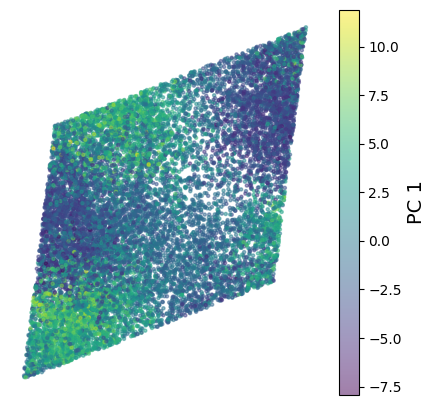

In [10]:
spikes_pca_6,__,__ = pca(ssspikes, dim = 6)

plt.figure(figsize=(5,5))
plt.scatter(new_Z[:,0], new_Z[:,1], s=5, alpha=0.5, c=spikes_pca_6[:,0], cmap='viridis')
plt.axis('off')
# add a color bar
cbar = plt.colorbar()
cbar.set_label('PC 1', fontsize=14)

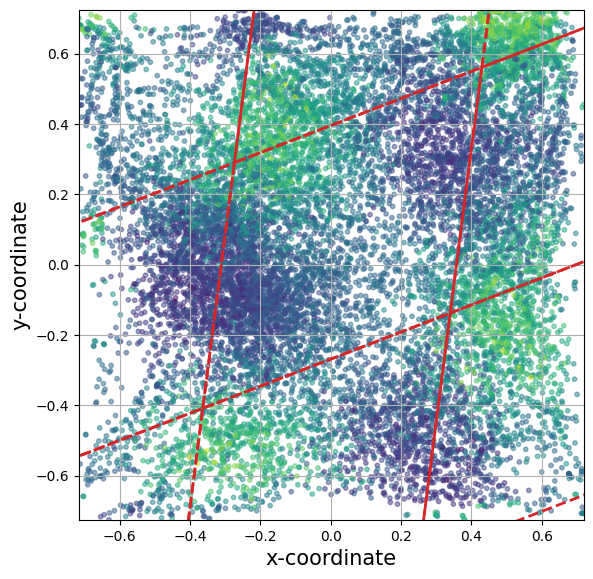

In [11]:
%matplotlib inline

fig, ax1 = plt.subplots(1, figsize=(6, 6))  

ax1.set_aspect('equal', 'box')
scatter1 = ax1.scatter(xx[movetimes], yy[movetimes], s=10, alpha=0.5, c=spikes_pca_6[:,0], cmap='viridis')

source = np.argmin(np.sqrt((xx[movetimes] - np.mean(xx[movetimes]))**2 + (yy[movetimes] - np.mean(yy[movetimes]))**2))
center_x = xx[movetimes[source]]
center_y = yy[movetimes[source]]

corners = np.array([
    [0, 0],
    vec1,
    vec1 + vec2,
    vec2,
    [0, 0]
])
new_corners = corners + np.array([center_x, center_y]) - vec1 / 2 - vec2 / 2
ax1.plot(new_corners[:, 0], new_corners[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners + vec1)[:, 0], (new_corners + vec1)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners - vec1)[:, 0], (new_corners - vec1)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners + vec2)[:, 0], (new_corners + vec2)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners - vec2)[:, 0], (new_corners - vec2)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners + vec1 + vec2)[:, 0], (new_corners + vec1 + vec2)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners - vec1 + vec2)[:, 0], (new_corners - vec1 + vec2)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners + vec1 - vec2)[:, 0], (new_corners + vec1 - vec2)[:, 1], lw=2, c='tab:red', linestyle='--')
ax1.plot((new_corners - vec1 - vec2)[:, 0], (new_corners - vec1 - vec2)[:, 1], lw=2, c='tab:red', linestyle='--')

# add axis label
ax1.set_xlabel("x-coordinate", fontsize=15)
ax1.set_ylabel("y-coordinate", fontsize=15)

# Restrict axis to xx and yy points
ax1.set_xlim(xx[movetimes].min(), xx[movetimes].max())
ax1.set_ylim(yy[movetimes].min(), yy[movetimes].max())

ax1.grid(True)



plt.tight_layout()
plt.show()

## Isometry experiment

In [12]:
spikes_normalised = ssspikes /  np.linalg.norm(ssspikes, axis=1, keepdims=True)

W = kneighbors_graph(spikes_normalised, n_neighbors=10, mode='distance', include_self=False)
G=nx.from_scipy_sparse_array(W, parallel_edges=False, create_using=None, edge_attribute='weight')

num_components = nx.number_connected_components(G)
print(f"Number of connected components in G_pca: {num_components}")

Number of connected components in G_pca: 1


In [13]:
source = np.argmin(np.sqrt((xx[movetimes] - np.mean(xx[movetimes]))**2 + (yy[movetimes] - np.mean(yy[movetimes]))**2))
print("source neuron: ", source)

source neuron:  13189


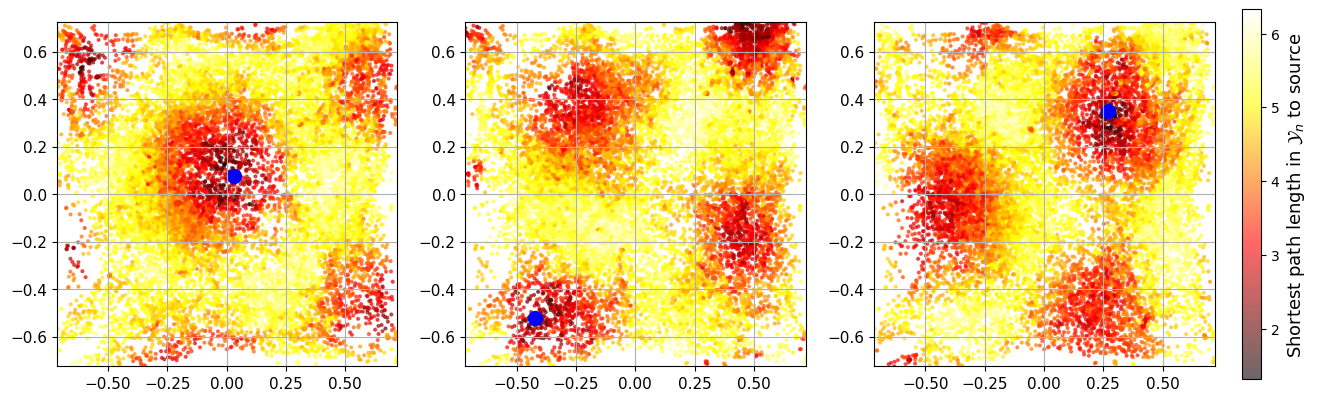

In [14]:
plt.figure(figsize=(18, 6))
sources = [13189, 100, 1001]

for j, source in enumerate(sources):
    manifold_path_lengths_dict = dict(nx.single_source_dijkstra_path_length(G, list(G.nodes)[source], weight='weight'))
    manifold_path_lengths = np.zeros(len(manifold_path_lengths_dict))
    for i in range(len(manifold_path_lengths_dict)):
        manifold_path_lengths[i] = manifold_path_lengths_dict[i]
    #smooth the manifold path lengths
    k_neighbors = 10
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(Z)
    distances, indices = nbrs.kneighbors(Z)
    weights = np.zeros_like(distances)
    for i in range(len(distances)):
        weights[i] = np.max(distances[i]) - distances[i]
    weights /= np.sum(weights, axis=1, keepdims=True)

    smoothed_lengths = np.zeros_like(manifold_path_lengths)
    for i in range(len(manifold_path_lengths)):
        smoothed_lengths[i] = np.sum(manifold_path_lengths[indices[i]] * weights[i])
    
    plt.subplot(1, len(sources), j + 1)
    scatter = plt.scatter(xx[movetimes], yy[movetimes], c=smoothed_lengths, cmap='hot', s=4, alpha=0.6)
    plt.scatter(xx[movetimes][source], yy[movetimes][source], color='blue', s=100)
    plt.axis('square')
    plt.tick_params(axis='both', labelsize=11)  # Reduce the font size of axis numbers
    plt.grid(True)
    plt.xlim(xx[movetimes].min(), xx[movetimes].max())
    plt.ylim(yy[movetimes].min(), yy[movetimes].max())

cbar = plt.colorbar(scatter, ax=plt.gcf().axes, location='right', shrink=0.8, pad=0.02, alpha=0.8)
cbar.set_label(r'Shortest path length in $\mathcal{Y}_n$ to source', fontsize=13)

In [15]:
source = np.argmin(np.sqrt((xx[movetimes] - np.mean(xx[movetimes]))**2 + (yy[movetimes] - np.mean(yy[movetimes]))**2))

manifold_path_lengths_dict = dict(nx.single_source_dijkstra_path_length(G, list(G.nodes)[source],weight='weight'))
manifold_path_lengths = np.zeros(len(manifold_path_lengths_dict))
for i in range(len(manifold_path_lengths_dict)):
    manifold_path_lengths[i] = manifold_path_lengths_dict[i]

In [16]:
# square path lengths
K=10
W_square = kneighbors_graph(Z, n_neighbors=K, mode='distance', include_self=False)
G_square=nx.from_scipy_sparse_array(W_square, parallel_edges=False, create_using=None, edge_attribute='weight')
num_components = nx.number_connected_components(G_square)
print(f"Number of connected components in G: {num_components}")

true_paths = dict(nx.single_source_dijkstra_path(G_square, list(G_square.nodes)[source],weight='weight'))
true_path_lengths_dict = dict(nx.single_source_dijkstra_path_length(G_square, list(G_square.nodes)[source],weight='weight'))
true_path_lengths = np.zeros(len(true_path_lengths_dict))
for i in range(len(true_path_lengths_dict)):
    true_path_lengths[i] = true_path_lengths_dict[i]

Number of connected components in G: 1


In [17]:
new_Z = np.zeros(Z.shape)
for i in [-1,0,1]:  
    for j in [-1,0,1]:  
        offset = i * vec1 + j * vec2
        corners = np.array([
            [0, 0],
            vec1,
            vec1 + vec2,
            vec2,
            [0, 0]
        ]) + offset - vec1/2 - vec2/2
        
        point_idx = points_in_rhombus(Z, corners)
        points = np.column_stack((xx[movetimes][point_idx]-offset[0], yy[movetimes][point_idx]-offset[1]))
        new_Z[point_idx, :] = points


# Smooth the manifold path lengths 
k_neighbors = 10
nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(new_Z)
distances, indices = nbrs.kneighbors(new_Z)
weights = np.zeros_like(distances)
for i in range(len(distances)):
    weights[i] = np.max(distances[i]) - distances[i]
weights /= np.sum(weights, axis=1, keepdims=True)

smoothed_lengths = np.zeros_like(manifold_path_lengths)
for i in range(len(manifold_path_lengths)):
    smoothed_lengths[i] = np.sum(manifold_path_lengths[indices[i]] * weights[i])

In [18]:
# naive rhombus paths
W_naive = kneighbors_graph(new_Z, n_neighbors=10, mode='distance', include_self=False)
G_naive=nx.from_scipy_sparse_array(W_naive, parallel_edges=False, create_using=None, edge_attribute='weight')

naive_rhombus_paths = dict(nx.single_source_dijkstra_path(G_naive, list(G_naive.nodes)[source],weight='weight'))
naive_rhombus_path_lengths_dict = dict(nx.single_source_dijkstra_path_length(G_naive, list(G_naive.nodes)[source],weight='weight'))
naive_rhombus_path_lengths = np.zeros(len(naive_rhombus_path_lengths_dict))
for i in range(len(naive_rhombus_path_lengths_dict)):
    naive_rhombus_path_lengths[i] = naive_rhombus_path_lengths_dict[i]

In [19]:
#retesselate the rhombus
re_tesselated_Z = np.zeros((0, 2))
for i in [-1,0,1]:  
    for j in [-1,0,1]:  
        offset = i * vec1 + j * vec2
        corners = np.array([
            [0, 0],
            vec1,
            vec1 + vec2,
            vec2,
            [0, 0]
        ]) + offset - vec1/2 - vec2/2
        
        points = np.column_stack((new_Z[:,0]+offset[0], new_Z[:,1]+offset[1]))
        re_tesselated_Z = np.vstack((re_tesselated_Z, points))

W_rhombus = kneighbors_graph(re_tesselated_Z, n_neighbors=10, mode='distance', include_self=False)
G_rhombus=nx.from_scipy_sparse_array(W_rhombus, parallel_edges=False, create_using=None, edge_attribute='weight')

num_components = nx.number_connected_components(G_rhombus)
print(f"Number of connected components in G_pca: {num_components}")


Number of connected components in G_pca: 1


In [20]:
# rhombus path lengths
rhombus_paths = dict(nx.single_source_dijkstra_path(G_rhombus, list(G_rhombus.nodes)[source],weight='weight'))
rhombus_path_lengths_dict = dict(nx.single_source_dijkstra_path_length(G_rhombus, list(G_rhombus.nodes)[source],weight='weight'))
rhombus_path_lengths = np.zeros(len(rhombus_path_lengths_dict))
for i in range(len(rhombus_path_lengths_dict)):
    rhombus_path_lengths[i] = rhombus_path_lengths_dict[i]

stacked_path_lengths = np.zeros((15000, 9))
for i in range(9):
    stacked_path_lengths[:,i] = rhombus_path_lengths[i*15000:(i+1)*15000]
    
min_path_lengths = np.min(stacked_path_lengths, axis=1)
rhombus_path_lengths = min_path_lengths

min_id = np.argmin(stacked_path_lengths, axis=1)
min_paths = {}
for i in range(15000):
    min_path = rhombus_paths[i + min_id[i]*15000]
    min_path = np.array(min_path)  
    idx = np.where(min_path >= 15000)
    min_path[idx] = min_path[idx] - 15000 * min_id[i]
    min_paths[i] = min_path

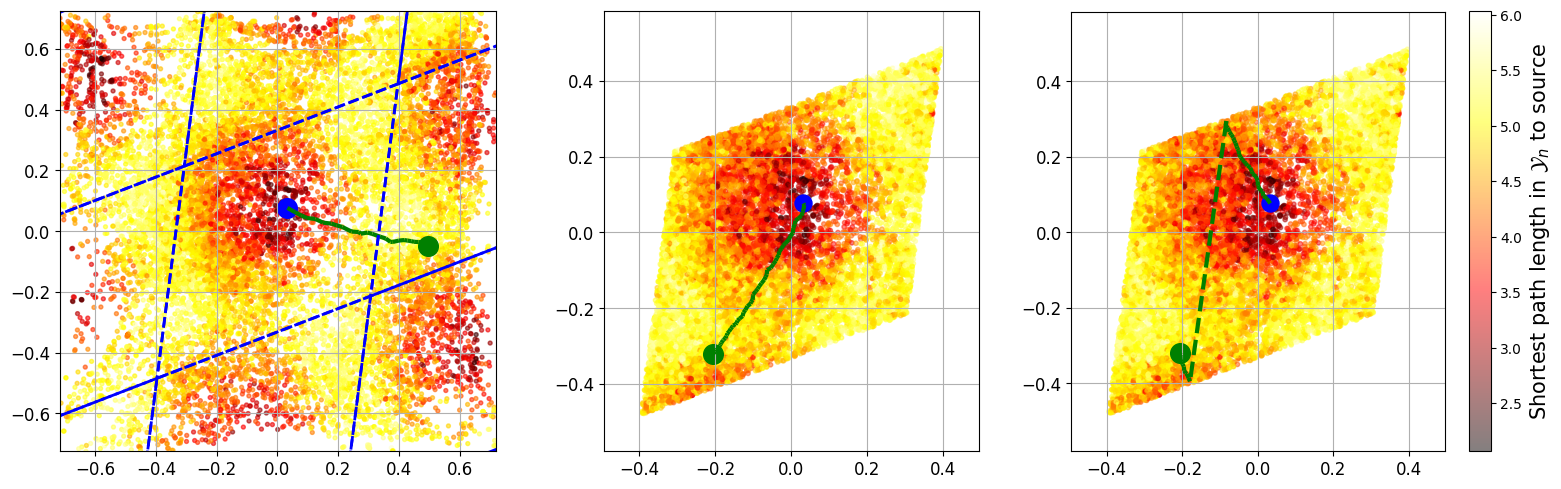

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  

source = np.argmin(np.sqrt((xx[movetimes] - np.mean(xx[movetimes]))**2 + (yy[movetimes] - np.mean(yy[movetimes]))**2))
poi = np.argmin(np.sqrt((xx[movetimes] - 0.5)**2 + (yy[movetimes] - -0.05)**2))


ax1 = axes[0]
ax1.set_aspect('equal', 'box')
scatter1 = ax1.scatter(xx[movetimes], yy[movetimes], s=8, alpha=0.6, c=smoothed_lengths, cmap='hot')
ax1.scatter(xx[movetimes[source]], yy[movetimes[source]], color='blue', s=200)
ax1.scatter(xx[movetimes][poi], yy[movetimes][poi], color='green', s=200)
path = true_paths[poi]
for i in range(len(path)-1):
    ax1.plot([xx[movetimes][path[i]], xx[movetimes][path[i+1]]],
            [yy[movetimes][path[i]], yy[movetimes][path[i+1]]],
            linestyle='--', color='green', alpha=1, linewidth=3)

center_x = xx[movetimes[source]]
center_y = yy[movetimes[source]]

corners = np.array([
    [0, 0],
    vec1,
    vec1 + vec2,
    vec2,
    [0, 0]
])

new_corners = corners - vec1 / 2 - vec2 / 2
ax1.plot(new_corners[:, 0], new_corners[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners + vec1)[:, 0], (new_corners + vec1)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners - vec1)[:, 0], (new_corners - vec1)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners + vec2)[:, 0], (new_corners + vec2)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners - vec2)[:, 0], (new_corners - vec2)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners + vec1 + vec2)[:, 0], (new_corners + vec1 + vec2)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners - vec1 + vec2)[:, 0], (new_corners - vec1 + vec2)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners + vec1 - vec2)[:, 0], (new_corners + vec1 - vec2)[:, 1], lw=2, c='blue', linestyle='--')
ax1.plot((new_corners - vec1 - vec2)[:, 0], (new_corners - vec1 - vec2)[:, 1], lw=2, c='blue', linestyle='--')
ax1.set_xlim(xx[movetimes].min(), xx[movetimes].max())
ax1.set_ylim(yy[movetimes].min(), yy[movetimes].max())
ax1.grid(True)
ax1.tick_params(axis='both', labelsize=12)  


ax2 = axes[2]
scatter2 = ax2.scatter(new_Z[:, 0], new_Z[:, 1], s=10, alpha=0.5, c=smoothed_lengths, cmap='hot')
ax2.scatter(xx[movetimes[source]], yy[movetimes[source]], color='blue', s=150)
ax2.axis('square')
ax2.set_xlim(new_Z[:, 0].min()-0.1, new_Z[:, 0].max()+0.1)
ax2.set_ylim(new_Z[:, 1].min()-0.1, new_Z[:, 1].max()+0.1)
ax2.scatter(new_Z[poi, 0], new_Z[poi, 1], color='green', s=200)
path = min_paths[poi]
for i in range(len(path)-1):
    ax2.plot([new_Z[path[i], 0], new_Z[path[i+1], 0]],
            [new_Z[path[i], 1], new_Z[path[i+1], 1]],
            linestyle='--', color='green', alpha=1, linewidth=3)
ax2.grid(True)
ax2.tick_params(axis='both', labelsize=12) 


ax3 = axes[1]
scatter3 = ax3.scatter(new_Z[:, 0], new_Z[:, 1], s=10, alpha=0.5, c=smoothed_lengths, cmap='hot')
ax3.scatter(xx[movetimes[source]], yy[movetimes[source]], color='blue', s=150)
ax3.axis('square')
ax3.set_xlim(new_Z[:, 0].min()-0.1, new_Z[:, 0].max()+0.1)  
ax3.set_ylim(new_Z[:, 1].min()-0.1, new_Z[:, 1].max()+0.1) 
ax3.scatter(new_Z[poi, 0], new_Z[poi, 1], color='green', s=200)
path = naive_rhombus_paths[poi]
for i in range(len(path)-1):
    ax3.plot([new_Z[path[i], 0], new_Z[path[i+1], 0]],
            [new_Z[path[i], 1], new_Z[path[i+1], 1]],
            linestyle='--', color='green', alpha=1, linewidth=3)
ax3.grid(True)
ax3.tick_params(axis='both', labelsize=12)  

cbar2 = fig.colorbar(scatter2, ax=ax2)
cbar2.set_label(r'Shortest path length in $\mathcal{Y}_n$ to source', fontsize=15)

plt.tight_layout()
plt.show()


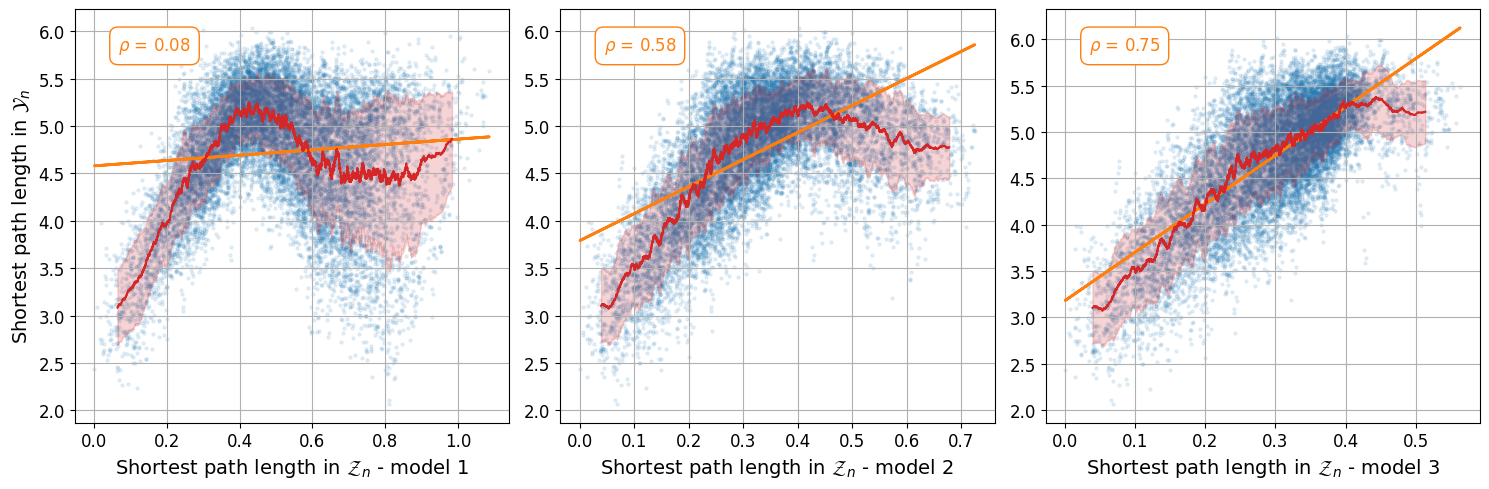

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(true_path_lengths, smoothed_lengths, s=5, alpha=0.1, color='tab:blue')
slope, intercept, r_value, p_value, std_err = linregress(true_path_lengths, smoothed_lengths)
plt.plot(true_path_lengths, slope * true_path_lengths + intercept, color='tab:orange', linewidth=2)
plt.text(0.1, 0.9, rf'$\rho$ = {r_value:.2f}', fontsize=12, transform=plt.gca().transAxes, color='tab:orange', bbox=dict(facecolor='white', edgecolor='tab:orange', boxstyle='round,pad=0.5'))
idx = np.argsort(true_path_lengths)
true_path_lengths_sorted = true_path_lengths[idx]
smoothed_lengths_sorted = smoothed_lengths[idx]
window_size = 150
rolling_mean_true = np.convolve(true_path_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_mean_smoothed = np.convolve(smoothed_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_std_smoothed = np.array([np.std(smoothed_lengths_sorted[i:i+window_size]) for i in range(len(smoothed_lengths_sorted)-window_size+1)])
lower_bound = rolling_mean_smoothed - 1 * rolling_std_smoothed
upper_bound = rolling_mean_smoothed + 1 * rolling_std_smoothed
plt.plot(rolling_mean_true, rolling_mean_smoothed, color='tab:red')
plt.fill_between(rolling_mean_true, lower_bound, upper_bound, color='tab:red', alpha=0.2, label='95% CI')
plt.xlabel(r"Shortest path length in $\mathcal{Z}_n$ - model 1", fontsize=14) 
plt.ylabel(r"Shortest path length in $\mathcal{Y}_n$", fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', labelsize=12)  

plt.subplot(1, 3, 2)
plt.scatter(naive_rhombus_path_lengths, smoothed_lengths, s=5, alpha=0.1, color='tab:blue')
slope, intercept, r_value, p_value, std_err = linregress(naive_rhombus_path_lengths, smoothed_lengths)
plt.plot(naive_rhombus_path_lengths, slope * naive_rhombus_path_lengths + intercept, color='tab:orange', linewidth=2)
plt.text(0.1, 0.9, rf'$\rho$ = {r_value:.2f}', fontsize=12, transform=plt.gca().transAxes, color='tab:orange', bbox=dict(facecolor='white', edgecolor='tab:orange', boxstyle='round,pad=0.5'))
idx = np.argsort(naive_rhombus_path_lengths)
rhombus_path_lengths_sorted = naive_rhombus_path_lengths[idx]
smoothed_lengths_sorted = smoothed_lengths[idx]
window_size = 150
rolling_mean_rhombus = np.convolve(rhombus_path_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_mean_smoothed = np.convolve(smoothed_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_std_smoothed = np.array([np.std(smoothed_lengths_sorted[i:i+window_size]) for i in range(len(smoothed_lengths_sorted)-window_size+1)])
lower_bound = rolling_mean_smoothed - 1 * rolling_std_smoothed 
upper_bound = rolling_mean_smoothed + 1 * rolling_std_smoothed
plt.plot(rolling_mean_rhombus, rolling_mean_smoothed, color='tab:red')
plt.fill_between(rolling_mean_rhombus, lower_bound, upper_bound, color='tab:red', alpha=0.2, label='95% CI')
plt.xlabel(r"Shortest path length in $\mathcal{Z}_n$ - model 2", fontsize=14)    
plt.grid(True)
plt.tick_params(axis='both', labelsize=12) 

plt.subplot(1, 3, 3)
plt.scatter(rhombus_path_lengths, smoothed_lengths, s=5, alpha=0.1, color='tab:blue')
slope, intercept, r_value, p_value, std_err = linregress(rhombus_path_lengths, smoothed_lengths)
plt.plot(rhombus_path_lengths, slope * rhombus_path_lengths + intercept, color='tab:orange', linewidth=2)
plt.text(0.1, 0.9, rf'$\rho$ = {r_value:.2f}', fontsize=12, transform=plt.gca().transAxes, color='tab:orange', bbox=dict(facecolor='white', edgecolor='tab:orange', boxstyle='round,pad=0.5'))
idx = np.argsort(rhombus_path_lengths)
rhombus_path_lengths_sorted = rhombus_path_lengths[idx]
smoothed_lengths_sorted = smoothed_lengths[idx]
window_size = 150
rolling_mean_rhombus = np.convolve(rhombus_path_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_mean_smoothed = np.convolve(smoothed_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_std_smoothed = np.array([np.std(smoothed_lengths_sorted[i:i+window_size]) for i in range(len(smoothed_lengths_sorted)-window_size+1)])
lower_bound = rolling_mean_smoothed - 1 * rolling_std_smoothed 
upper_bound = rolling_mean_smoothed + 1 * rolling_std_smoothed
plt.plot(rolling_mean_rhombus, rolling_mean_smoothed, color='tab:red')
plt.fill_between(rolling_mean_rhombus, lower_bound, upper_bound, color='tab:red', alpha=0.2, label='95% CI')
plt.xlabel(r"Shortest path length in $\mathcal{Z}_n$ - model 3", fontsize=14)    
plt.grid(True)
plt.tick_params(axis='both', labelsize=12)  

plt.tight_layout()


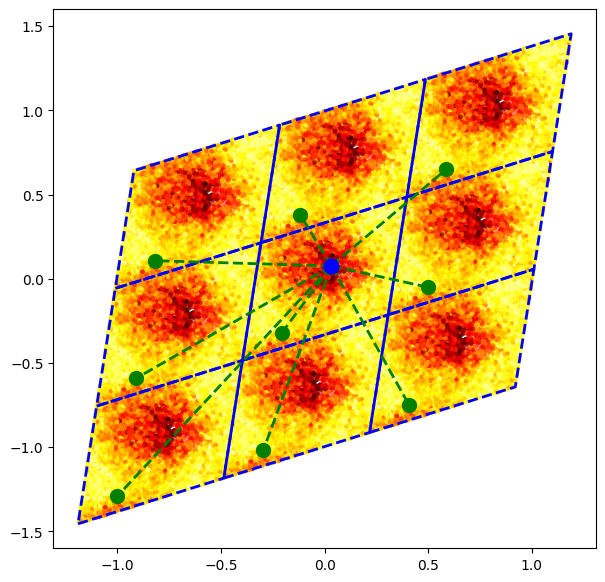

In [23]:
# plt new_Z re-tesselated in all the surrounding rhombii
plt.figure(figsize=(7, 7))
plt.plot(new_corners[:, 0], new_corners[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners + vec1)[:, 0], (new_corners + vec1)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners - vec1)[:, 0], (new_corners - vec1)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners + vec2)[:, 0], (new_corners + vec2)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners - vec2)[:, 0], (new_corners - vec2)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners + vec1 + vec2)[:, 0], (new_corners + vec1 + vec2)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners - vec1 + vec2)[:, 0], (new_corners - vec1 + vec2)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners + vec1 - vec2)[:, 0], (new_corners + vec1 - vec2)[:, 1], lw=2, c='blue', linestyle='--')
plt.plot((new_corners - vec1 - vec2)[:, 0], (new_corners - vec1 - vec2)[:, 1], lw=2, c='blue', linestyle='--')

# Loop to tessellate the rhombus
for i in [-1,0,1]:  
    for j in [-1,0,1]:  
        offset = i * vec1 + j * vec2
        offset_Z = new_Z + offset
        plt.scatter(offset_Z[:,0], offset_Z[:,1], s=5, alpha=0.5, c=smoothed_lengths, cmap='hot')
        plt.scatter(offset_Z[poi, 0], offset_Z[poi, 1], color='green', s=100)
        plt.plot([xx[movetimes][source], offset_Z[poi, 0]],
                [yy[movetimes][source], offset_Z[poi, 1]],
                linestyle='--', color='green', alpha=1, linewidth=2)
        plt.scatter(xx[movetimes][source], yy[movetimes][source], color='blue', s=100, zorder=10)


## Model 4

In [46]:
file_name =  rat_name + '_' + mod_name + '_' + sess_name 
if len(day_name)>0:
    file_name += '_' + day_name  

f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name  + '_decoding.npz',
    allow_pickle = True)
coords_OF = f['coordsbox']
times_OF = f['times_box']
f.close()  

In [45]:
sspikes,xx,yy,aa,tt = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = True, bSpeed = True)

In [47]:
spikes,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                         bSmooth = False, bSpeed = True)

In [48]:
times = np.where(np.sum(spikes>0, 1)>=1)[0]

sspikes = sspikes[times,:]
xx = xx[times]
yy = yy[times]

In [49]:
num_neurons = len(sspikes[0,:])
times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

ssspikes = preprocessing.scale(sspikes[movetimes,:],axis = 0)

In [50]:
coords_OF = coords_OF[movetimes,:]
torus_coords = coords_OF

In [51]:
pca_embedding = pca(ssspikes, 6)

In [53]:
R=2.5
r=1

x = (R + r*np.cos(torus_coords[:,0]))*np.cos(torus_coords[:,1])
y = (R + r*np.cos(torus_coords[:,0]))*np.sin(torus_coords[:,1])
z = r*np.sin(torus_coords[:,0])


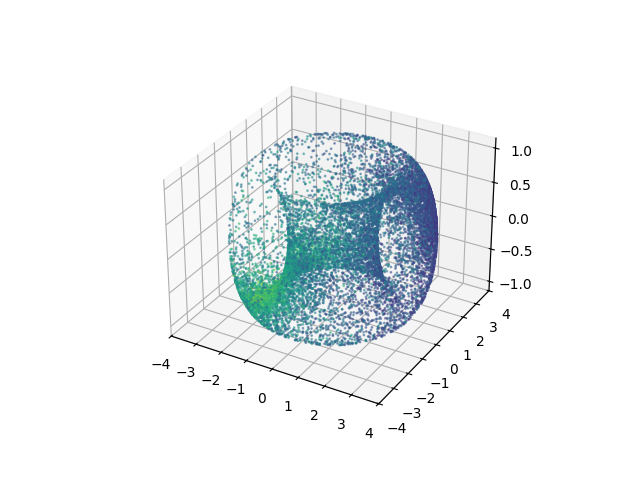

In [54]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1, c=pca_embedding[0][:, 0], cmap='viridis', alpha=0.5)
plt.show()

In [55]:
new_Z = np.column_stack((x, y, z))
K=10
W = kneighbors_graph(new_Z, n_neighbors=K, mode='distance', include_self=False)
G=nx.from_scipy_sparse_array(W, parallel_edges=False, create_using=None, edge_attribute='weight')

torus_path_lengths_dict = dict(nx.single_source_dijkstra_path_length(G, list(G.nodes)[source],weight='weight'))
torus_path_lengths = np.zeros(len(manifold_path_lengths_dict))
for i in range(len(torus_path_lengths_dict)):
    torus_path_lengths[i] = torus_path_lengths_dict[i]



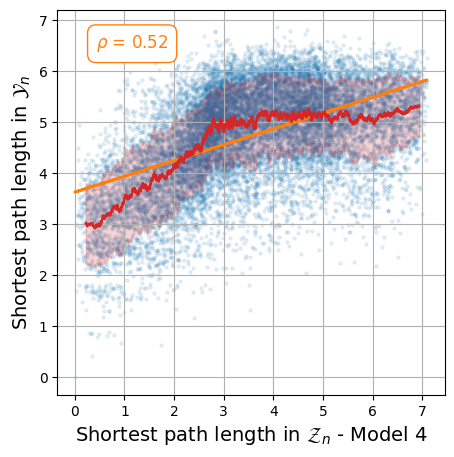

In [57]:
%matplotlib inline

plt.figure(figsize=(5, 5))

plt.subplot(1, 1, 1)
plt.scatter(torus_path_lengths, manifold_path_lengths, s=5, alpha=0.1, color='tab:blue')
#add linear regression and add R^2 to top left of plot
slope, intercept, r_value, p_value, std_err = linregress(torus_path_lengths, manifold_path_lengths)
plt.plot(torus_path_lengths, slope * torus_path_lengths + intercept, color='tab:orange', linewidth=2)
plt.text(0.1, 0.9, rf'$\rho$ = {r_value:.2f}', fontsize=12, transform=plt.gca().transAxes, color='tab:orange', bbox=dict(facecolor='white', edgecolor='tab:orange', boxstyle='round,pad=0.5'))
# plot the moving average and associated confidence interval
idx = np.argsort(torus_path_lengths)
torus_path_lengths_sorted = torus_path_lengths[idx]
manifold_path_lengths_sorted = manifold_path_lengths[idx]
window_size = 150
rolling_mean_torus = np.convolve(torus_path_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_mean_smoothed = np.convolve(manifold_path_lengths_sorted, np.ones(window_size)/window_size, mode='valid')
rolling_std_smoothed = np.array([np.std(manifold_path_lengths_sorted[i:i+window_size]) for i in range(len(manifold_path_lengths_sorted)-window_size+1)])
lower_bound = rolling_mean_smoothed - 1 * rolling_std_smoothed
upper_bound = rolling_mean_smoothed + 1 * rolling_std_smoothed
plt.plot(rolling_mean_torus, rolling_mean_smoothed, color='tab:red')
plt.fill_between(rolling_mean_torus, lower_bound, upper_bound, color='tab:red', alpha=0.2, label='95% CI')
plt.xlabel(r"Shortest path length in $\mathcal{Z}_n$ - Model 4", fontsize=14) 
plt.ylabel(r"Shortest path length in $\mathcal{Y}_n$", fontsize=14)
plt.grid(True)

plt.show()